# 01 Clean data

This notebook cleans the data in ``data/00_raw``, and outputs the data in ``data/01_transformed``.  
We have a [readme](https://docs.google.com/document/d/1KNptTgujHjXXbZKJdZii28PmSVwae6pl4-3PE-36Di4/edit#) for the raw data files.

### Contents:
1. Read data files  
2. Add demographic and risk factor data  
2.1. Start with demographic data  
2.2 Add risk factor data  
2.3 Add in history of PUB  
3. Add outcome data  
3.1. GI data  
3.2. Cardiovascular data  
3.3. Hypertension data  
3.4. Cold/flu data  
3.5. Nausea data  
4. Data processing  
4.1. Add GI, severe_GI and TREATED labels  
4.2. Create binary features  
4.3. Discussion of missing values  
5. Split data and save

## 1. Read data files

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

In [2]:
DATA_PATH = os.path.join("../..", "data", "00_raw")

demog_df = pd.read_csv(os.path.join(DATA_PATH, "DEMOG-088C.txt"), sep = "\t")
endpoint_df = pd.read_csv(os.path.join(DATA_PATH,"ENDPT14.txt"), sep = "\t")
medhist_df = pd.read_csv(os.path.join(DATA_PATH,"MEDHIST-088C.txt"), sep = "\t")
conthrp_df = pd.read_csv(os.path.join(DATA_PATH,"CONTHRP-088C.txt"), sep = "\t")
drugexp_df = pd.read_csv(os.path.join(DATA_PATH,"DRUGEXP-088C.txt"), sep = "\t")
ae_df = pd.read_csv(os.path.join(DATA_PATH, "AE-088C.txt"), sep = "\t")
alcohol_df = pd.read_csv(os.path.join(DATA_PATH, "ALCOHOL-088C.txt"), sep = "\t")
tobacco_df = pd.read_csv(os.path.join(DATA_PATH,"TOBACCO-088C.txt"), sep = "\t")
riskfctr_df = pd.read_csv(os.path.join(DATA_PATH, "VIGOR_RISKFCTR.mrk-zaa0000119.dat"), 
                          sep = "\t")

## 2. Add demographic and risk factor data

We will construct a dataframe ``full_df`` step-wise.

### 2.1. Start with demographic data

In [3]:
demog_df.columns

Index(['CMPDNUM', 'PROTOCOL', 'STUDYNUM', 'AN', 'AGE', 'AGE_UNIT', 'GENDER',
       'RACE', 'TREATMNT', 'COUNTRY', 'DAYS_IN', 'DAYS_TRT', 'DISPOSTN',
       'HEIGHT_C', 'WEIGHT_K'],
      dtype='object')

In [4]:
# Create the data frame from demog df
full_df = demog_df

# Convert columns to numeric
full_df["HEIGHT_C"] = full_df["HEIGHT_C"].apply(lambda x: np.nan if x == "." 
                                                else float(x))
full_df["WEIGHT_K"] = full_df["WEIGHT_K"].apply(lambda x: np.nan if x == "." 
                                                else float(x))

Add life expectancy data

In [5]:
countries = full_df.COUNTRY.unique()

# Downloaded from https://ourworldindata.org/life-expectancy (world bank)
# https://ourworldindata.org/grapher/life-expectancy-at-birth-total-years

life_expect = pd.read_csv(os.path.join(DATA_PATH, 
                                       "life-expectancy-at-birth-total-years.csv"), 
                          sep = ",")
life_expect = life_expect.rename(columns = {'Entity': 'COUNTRY', 
                'Life expectancy at birth, total (years) (years)': "Life_Expect"})
life_expect = life_expect[(life_expect["COUNTRY"].isin(countries)) & 
                          (life_expect["Year"]==1998)].reset_index()
life_expect = life_expect[['COUNTRY', "Life_Expect"]]

full_df = pd.merge(full_df, life_expect, how="left")

### 2.2 Add risk factor data

Try to find H Pylori data

In [6]:
key_terms = ["pylori", "Helicobacter"]
hpylori_terms = np.unique(np.hstack(([s for s in ae_df.REPTTERM.unique() 
                                      if np.any([key.lower() in s.lower() 
                                                 for key in key_terms])],
                                   [str(s) for s in medhist_df.REPTTERM.unique() 
                                    if np.any([key.lower() in str(s).lower() 
                                               for key in key_terms])])))

print('H Pylori terms are ', hpylori_terms)

hyplori_pos_patients = medhist_df[medhist_df.REPTTERM.isin(hpylori_terms)].AN.unique()
print(f"Number of patients with H Pylori history: {len(hyplori_pos_patients)}")

H Pylori terms are  ['Helicobacter gastritis' 'Helicobacter infection'
 'anti-Helicobacter pylori antibody positive' 'prepyloric ulcer'
 'pyloric stenosis']
Number of patients with H Pylori history: 43


Warning: This number don't match anywhere close to 43% ~ 3440 patients as claimed in line 2 of page B-29  
of 2000-06-22 SI document. We hence omit this data.

In [7]:
riskfctr_df.columns

Index(['ALLOC', 'AGE', 'AGEGRP', 'SEXGRP', 'SMKGRP', 'HYPGRP', 'DBTGRP',
       'CHLGRP', 'ASPFDA', 'ASCGRP', 'STUDY', 'BASENUM', 'TRMT', 'PSTRDS',
       'PNSAIDS', 'PNAPRXN'],
      dtype='object')

In [8]:
# Steroid use in "VIGOR_RISKFCTR.mrk-zaa0000119.dat" under PSTRDS
# patient 1751 does not have an entry in alcohol_df

full_df = full_df.merge(alcohol_df[["AN", "RESPONSE"]], on = "AN", how = "outer") \
                 .rename(columns = {"RESPONSE" : "ALCOHOL"}) \
                 .merge(tobacco_df[tobacco_df.QUESTION == "Cigarette Use"] \
                        [["AN", "RESPONSE"]], on = "AN") \
                 .rename(columns = {"RESPONSE" : "SMOKING"}) \
                 .merge(riskfctr_df.drop(columns = ["AGE", "SEXGRP", "STUDY", 
                                                    "SMKGRP", "BASENUM", "TRMT"]), 
                        left_on = "AN", right_on = "ALLOC") \
                 .drop(columns = ["ALLOC"]) \
                 .set_index("AN")
#full_df["HPYLORI"] = full_df.index.isin(hyplori_pos_patients).astype(int)

### 2.3 Add in history of PUB

Bombardier et al. claims that the randomization in the VIGOR study was stratified "according to the presence or absence of  
a history of gastroduodenal ulcer, upper gastrointestinal bleeding, and gastroduodenal perforation". We use this as the  
definition of PUB prior history, and came up with a list of reported terms that fell under this definition.

More precisely, we searched in `medhist_df` for terms that seemed to fall under these categories.

In [9]:
gastro_history_terms = ['gastrointestinal bleeding', 'gastroduodenal ulcer', 
                        'gastric perforation', 'perforating duodenal ulcer', 
                        'perforating gastric ulcer', 'gastrointestinal ulcer', 
                        'gastric ulcer','perforating duodenal ulcer', 
                        'perforating gastric ulcer', 'perforating hemorrhagic gastric ulcer', 
                        'hemorrhagic duodenal ulcer', 'hemorrhagic peptic ulcer', 
                        'gastrointestinal submucosal hemorrhage', 'hemorrhagic gastric ulcer', 
                        'prepyloric ulcer', 'omental patch (perforating duodenal ulcer)',
                        'duodenal ulcer', 'peptic ulcer', 'erosive gastritis', 
                        'gastric erosion','duodenal erosion', 'gastroduodenitis', 
                        'gastric hemorrhage']

pub_df = medhist_df.loc[medhist_df.REPTTERM.isin(gastro_history_terms)]

# Patients with pub history
patients_with_history = np.unique(pub_df.AN)

full_df['PUB_PRIOR_HISTORY'] = full_df.index.isin(patients_with_history).astype(int)

print("Number of patients with pub history: ", sum(full_df['PUB_PRIOR_HISTORY']), '\n')

Number of patients with pub history:  630 



This matches with Table 2 in Bombardier et al. (They had 316+314 = 630 patients with history.)

## 3. Add outcome data

### 3.1. GI data

In [10]:
event_types = endpoint_df.EVTTYPE.unique()
event_types

array(['d', 'p', 'b', 'g', 'o'], dtype=object)

d: duodenal ulcer  
p: perforation  
b: bleeding  
g: gastric ulcer  
o: obstruction  
*For more information, see Bombardier et al.*

In [11]:
# Create dictionaries whose keys are event types (d, g, b, etc.), and whose 
# values are the list of patients who experienced these events. Events can be 
# confirmed or not, complicated or not. We create a dictionary for each of 
# these modifiers

event_types = endpoint_df.EVTTYPE.unique()
patients_w_events = {}
patients_w_cfd_events = {}
patients_w_cmp_events = {}

for event_type in event_types:
    patients_w_events[event_type] = endpoint_df[endpoint_df.EVTTYPE == event_type] \
                                            .ALLOC.unique()
    
for event_type in event_types:
    patients_w_cfd_events[event_type] = endpoint_df[(endpoint_df.EVTTYPE == event_type) &
                                                   (endpoint_df.ENDPOINT == 1)] \
                                            .ALLOC.unique()
for event_type in event_types:
    patients_w_cmp_events[event_type] = endpoint_df[(endpoint_df.EVTTYPE == event_type) &
                                                   (endpoint_df.ENDPOINT == 4)] \
                                            .ALLOC.unique()

patients_w_events["all"] = endpoint_df.ALLOC.unique()
patients_w_cfd_events["all"] = endpoint_df[endpoint_df.ENDPOINT == 1].ALLOC.unique()
patients_w_cmp_events["all"] = endpoint_df[endpoint_df.ENDPOINT == 4].ALLOC.unique()

event_types = np.append(event_types, "all")

In [12]:
# We create our cleaned data frame starting with a column comprising the allocation 
# numbers for each patient
cleaned_endpoint_df = pd.DataFrame({"AN" : demog_df.AN})

# We add columns for each of the event types and modifiers
for event_type in event_types:
    cleaned_endpoint_df[event_type + "_event"] = cleaned_endpoint_df.AN \
                    .apply(lambda x: x in patients_w_events[event_type]).astype(int)
    cleaned_endpoint_df[event_type + "_event_cfd"] = cleaned_endpoint_df.AN \
                    .apply(lambda x: x in patients_w_cfd_events[event_type]).astype(int)
    cleaned_endpoint_df[event_type + "_event_cmp"] = cleaned_endpoint_df.AN \
                    .apply(lambda x: x in patients_w_cmp_events[event_type]).astype(int)

cleaned_endpoint_df = cleaned_endpoint_df.set_index("AN")

# Add an event date column
cleaned_endpoint_df["EVENTDT"] = endpoint_df.sort_values("EVENTDT").groupby("ALLOC") \
                                            .first()["EVENTDT"]

# Merge with full_df
full_df = full_df.merge(cleaned_endpoint_df, left_index = True, right_index = True)

#### 3.1.1 Add in time to event

In [13]:
"""
* Convert strings to datetime format
"""
drugexp_df.RAND_DT = pd.to_datetime(drugexp_df.RAND_DT)

"""
* Get Randomization date
"""
randDT = drugexp_df.RAND_DT.groupby(drugexp_df.AN).min().to_frame()

"""
* Merge date data with full dataframe
"""
full_df = full_df.merge(randDT, on = 'AN')

"""
* Incorporate event times
"""
full_df.EVENTDT = pd.to_datetime(full_df.EVENTDT)

"""
* Get time to event by taking the difference + 1
"""
full_df['time_to_GI'] = full_df.EVENTDT - full_df.RAND_DT
full_df['time_to_GI'] = full_df['time_to_GI'].dt.days
full_df['time_to_GI'].replace({np.nan: -2}, inplace = True)
full_df['time_to_GI'] = full_df['time_to_GI'] + 1
full_df['time_to_GI'].replace({-1: np.nan}, inplace = True)

# Check that NA values align
assert np.sum(~full_df['time_to_GI'].isna()) == full_df['all_event'].sum()

#### 3.1.2 Censoring checks -- DO NOT RUN THIS CURRENTLY

In [8]:
"""
* Get Censoring times
"""
full_df['BP_censoring'] = 0
patients = np.unique(drugexp_df.AN)

"""
* Function to calculate censoring time such that days treated
* must be 75% of the total censoring time
"""
def countTotal(subdata, daysTreated):
    subdata = subdata.sort_values(by=['START_DY'])
    start = subdata.START_DY.iloc[0]
    end = subdata.STOP_DY.iloc[0]
    
    for i in range(subdata.shape[0]):
        daysCan = subdata.STOP_DY.iloc[i] - subdata.START_DY.iloc[i] + 1
        endCan = subdata.STOP_DY.iloc[i]
        if (daysTreated)/(endCan-start+1) >= 0.75:
            end = endCan
    return end - start + 1

for patient in patients:
    subdata = drugexp_df.loc[drugexp_df.AN == patient]
    """
    * Remove 0 doses and placebo
    """
    subdata = subdata.loc[subdata.TOTLDOS > 0]
    subdata = subdata.loc[subdata.THERAPY != 'Placebo']
    subdata = subdata.loc[np.logical_and(subdata.START_DY > 0, subdata.STOP_DY > 0)]
    
    daysTreated = full_df['DAYS_TRT'].loc[full_df.index == patient]
    full_df['BP_censoring'].loc[full_df.index == patient] = \
                            countTotal(subdata, daysTreated.values[0])

In [10]:
"""
* Quantiles of DAYS_IN, doesn't seem to match Figure 1 of Bombadier et al.
"""
print(np.quantile(full_df['DAYS_IN'], 
                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7,0.8,0.9,1.0], axis=0))

"""
* Quantiles of censoring approximation, matches better with Figure 1
"""
print(np.quantile(full_df['DAYS_TRT'], 
                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7,0.8,0.9,1.0], axis=0))

"""
* Quantiles of BP approximation, matches better with Figure 1
"""
print(np.quantile(full_df['BP_censoring'], 
                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6 ,0.7,0.8,0.9,1.0], axis=0))

[246. 260. 274. 287. 296. 307. 317. 330. 349. 416.]
[ 47. 145. 239. 252. 271. 287. 299. 312. 334. 396.]
[ 47. 147. 239. 253. 273. 288. 301. 314. 336. 396.]


### 3.2. Cardiovascular data

#### Notes on non-GI events:  
- In ``ae_df``, there is a field ``PERIOD = ['Treatment', 'Post-Study', 'Pre-Treatment']``.  
We drop 'Pre-Treatment' events.
- ``REL_DAY`` is the time to event; I verified using ``ae_df.REL_DAY == ae_df.START_DT - full_df.RAND_DT + 1``
- Other fields that may be of relevance:  
`"AN", "AE_CONT", 'AE_TYPE','aedurdays', 'ACTION', 'CAUSAL'`,  
`"confirmedCVT", 'REPTTERM', 'INTENSIT','PERIOD', 'REL_DAY' 'SERIOUS', 'OUTCOME'`
     


For cardio-vascular events, we don't have to hunt for it since they already defined it in the following field:  
``confirmedCVT = 1`` (Confirmed), ``0`` (not cardio related) and ``-1`` (rejected by panels).

We may do two kinds of analysis, including and excluding -1

In [14]:
#### Exluding -1 ####
ae_df["cfd_cardio"] = (ae_df["confirmedCVT"] == 1) & \
                      (ae_df['PERIOD'] != 'Pre-Treatment')
patients_with_cardio_issues = ae_df[ae_df["cfd_cardio"]==1].AN.unique()
print('Patients with confirmed cardiovascular event = %d'% \
      (len(patients_with_cardio_issues)))
print('Patients with multiple cfd cardiovascular event = %d'% \
      (sum(ae_df[ae_df["cfd_cardio"]==1].AN.value_counts()>1)))
print('The terms for confirmed cardiovascular issues are ')
print(ae_df[ae_df["cfd_cardio"]==1]["REPTTERM"].value_counts())
print()

full_df['cfd_cardio'] = 0
full_df['cfd_cardio'].loc[full_df.index.isin(patients_with_cardio_issues)] = 1

# Adding time to event
full_df = full_df.merge(ae_df[ae_df["cfd_cardio"]==1].REL_DAY.groupby(ae_df.AN) \
                        .min().to_frame(),
                        on="AN", how='left')
full_df["time_to_cfd_cardio"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)


#### Including -1 ####
ae_df["all_cardio"] = ((ae_df["confirmedCVT"] == 1) |(ae_df["confirmedCVT"] == -1)) & \
                      (ae_df['PERIOD'] != 'Pre-Treatment')
patients_with_cardio_issues = ae_df[ae_df["all_cardio"]==1].AN.unique()
print('Patients with all cardiovascular event = %d'%(len(patients_with_cardio_issues)))
print('Patients with multiple all cardiovascular event = %d'% \
      (sum(ae_df[ae_df["all_cardio"]==1].AN.value_counts()>1)))
print('The terms for all cardiovascular issues are ')
print(ae_df[ae_df["all_cardio"]==1]["REPTTERM"].value_counts())
print()

full_df['all_cardio'] = 0
full_df['all_cardio'].loc[full_df.index.isin(patients_with_cardio_issues)] = 1

# Adding time to event
full_df = full_df.merge(ae_df[ae_df["all_cardio"]==1].REL_DAY.groupby(ae_df.AN) \
                        .min().to_frame(),
                        on="AN", how='left')
full_df["time_to_all_cardio"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)

#### To check the validity of REL_DAY with other dataframes ####
# ae_df[(ae_df.AN==an) & (ae_df.cardio==1)].START_DT.index.values[0]
# full_df[(full_df.AN==an) & (full_df.cardio==1)].RAND_DT.index.values[0]

Patients with confirmed cardiovascular event = 59
Patients with multiple cfd cardiovascular event = 2
The terms for confirmed cardiovascular issues are 
myocardial infarction                          20
cerebrovascular accident                       12
deep venous thrombosis                          5
acute myocardial infarction                     4
transient ischemic attack                       4
unstable angina                                 3
angina pectoris                                 2
coronary artery disease                         2
hemiparesis                                     1
intracranial hemorrhage                         1
ventricular fibrillation                        1
cerebral infarction                             1
acute inferoposterior myocardial infarction     1
arterial embolism                               1
cardiac arrest                                  1
embolic stroke                                  1
acute inferior myocardial infarction           

### 3.3. Hypertension data

Search for the key terms and remove *hypotension*; 90% of them are stated directly as hypertension  
and other are minor variants (several for same individual)

In [15]:
# search for tension in REPTTERM  but NOT hypotension
sub = "tension"
tension_terms = np.unique([s for s in ae_df.REPTTERM.unique() 
                           if sub.lower() in s.lower() and "hypo" not in s.lower()])
#print('Hypertension terms are ', tension_terms, '\n Will remove tension headache')
idx = np.where(tension_terms=='tension headache')[0]
tension_terms = np.delete(tension_terms, idx)
print('Hypertension terms are ', tension_terms)

print(ae_df[ae_df.REPTTERM.isin(tension_terms)]["REPTTERM"].value_counts())
ae_df["all_hypertension"] = ae_df.REPTTERM.apply(lambda x: 1 if x in tension_terms 
                                                 else 0)
# includes other kinds of hypertension, like 'diastolic/labile hypertension'..
ae_df["just_hypertension"] = ae_df.REPTTERM.apply(lambda x: 1 
                                                  if x == "hypertension" else 0)
# includes only direct hypertension mention

######## hypertension ########
# Removing 'Pre-Treatment' events 
ae_df["just_hypertension"] = (ae_df["just_hypertension"] == 1) & \
                             (ae_df['PERIOD'] != 'Pre-Treatment')
patients_with_tension_issues = ae_df[ae_df["just_hypertension"]==1].AN.unique()
full_df['just_hypertension'] = 0
full_df['just_hypertension'].loc[full_df.index.isin(patients_with_tension_issues)] = 1
print('Patients with hyper-tension = %d'%(len(patients_with_tension_issues)))
print('Patients with multiple hyper-tension= %d'% \
      (sum(ae_df[ae_df["just_hypertension"]==1].AN.value_counts()>1)))


# adding time to event
full_df = full_df.merge(ae_df[ae_df["just_hypertension"]==1].REL_DAY \
                        .groupby(ae_df.AN).min().to_frame(),
                        on="AN", how='left')
full_df["time_to_just_hypertension"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)


######## all_hypertension ########
# Removing 'Pre-Treatment' events 
ae_df["all_hypertension"] = (ae_df["all_hypertension"] == 1) & \
                            (ae_df['PERIOD'] != 'Pre-Treatment')
patients_with_tension_issues = ae_df[ae_df["all_hypertension"]==1].AN.unique()
full_df['all_hypertension'] = 0
full_df['all_hypertension'].loc[full_df.index.isin(patients_with_tension_issues)] = 1
print('Patients with ALL hyper-tension = %d'%(len(patients_with_tension_issues)))
print('Patients with multiple ALL hyper-tension= %d'% \
      (sum(ae_df[ae_df["all_hypertension"]==1].AN.value_counts()>1)))


# adding time to event
full_df = full_df.merge(ae_df[ae_df["all_hypertension"]==1].REL_DAY \
                        .groupby(ae_df.AN).min().to_frame(),
                        on = "AN", how = 'left')
full_df["time_to_all_hypertension"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)

Hypertension terms are  ['borderline hypertension' 'diastolic hypertension' 'hypertension'
 'hypertension uncontrolled with medication' 'labile hypertension'
 'pulmonary hypertension' 'systolic hypertension'
 'uncontrolled hypertension']
hypertension                                 616
uncontrolled hypertension                      7
hypertension uncontrolled with medication      7
systolic hypertension                          5
borderline hypertension                        4
diastolic hypertension                         2
labile hypertension                            2
pulmonary hypertension                         2
Name: REPTTERM, dtype: int64
Patients with hyper-tension = 543
Patients with multiple hyper-tension= 56
Patients with ALL hyper-tension = 567
Patients with multiple ALL hyper-tension= 60


567 patients had ALL hypertension, 60 patients had multiple tension entries, 20 of which are repeated with  
DURATION AND TOTLDOS as the only different fields between the two entries, 35 of them had two  
different hypertension evets, and 5 of them had 3 tension related events 

### 3.4 Cold/flu data

In [16]:
key_terms = ["flue", "cold", "cough"]
flu_terms = np.unique([s for s in ae_df.REPTTERM.unique() 
                       if np.any([key.lower() in s.lower() for key in key_terms])])
print('Flu terms are ', flu_terms)
print('')

print(ae_df[ae_df.REPTTERM.isin(flu_terms)]["REPTTERM"].value_counts())
ae_df["cold_cough_flu"] = ae_df.REPTTERM.apply(lambda x: 1 if x in flu_terms else 0)
## remove pre-treatment
ae_df["cold_cough_flu"] = (ae_df["cold_cough_flu"] == 1) & \
                          (ae_df['PERIOD'] != 'Pre-Treatment') 
patients_with_issues = ae_df[ae_df["cold_cough_flu"]==1].AN.unique()
full_df['cold_cough_flu'] = 0
full_df['cold_cough_flu'].loc[full_df.index.isin(patients_with_issues)] = 1
print('Unique Patients with cold-cough-flu symptoms = %d'% \
      (len(patients_with_issues)))
print('Patients with multiple cold-cough-flu symptoms = %d'% \
      (sum(ae_df[ae_df["cold_cough_flu"]==1].AN.value_counts()>1)))

# adding time to event
full_df = full_df.merge(ae_df[ae_df["cold_cough_flu"]==1].REL_DAY.groupby(ae_df.AN) \
                        .min().to_frame(),
                        on="AN", how='left')
full_df["time_to_cold_cough_flu"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)

Flu terms are  ['chest cold' 'cold sore' 'cold sweat' 'cold symptoms' 'common cold'
 'cough' 'dry cough' 'head cold' 'influenza' 'influenza symptoms'
 'productive cough']

influenza symptoms    166
common cold           160
cough                 113
influenza             104
cold symptoms          46
head cold              31
dry cough              13
cold sore               9
productive cough        6
chest cold              5
cold sweat              1
Name: REPTTERM, dtype: int64
Unique Patients with cold-cough-flu symptoms = 525
Patients with multiple cold-cough-flu symptoms = 93


### 3.5 Nausea data

In [17]:
key_terms = ["nausea", "vomit", "dizz"]
nausea_terms = np.unique([s for s in ae_df.REPTTERM.unique() 
                          if np.any([key.lower() in s.lower() 
                                     for key in key_terms])])
print('Nausea terms are ', nausea_terms)
idx = np.where(nausea_terms=='orthostatic dizziness')[0]
nausea_terms = np.delete(nausea_terms, idx)
print('We remove orthostatic dizziness ', nausea_terms)

print(ae_df[ae_df.REPTTERM.isin(nausea_terms)]["REPTTERM"].value_counts())
ae_df["naus_vomit_dizz"] = ae_df.REPTTERM.apply(lambda x:
                                                1 if x in nausea_terms else 0)
ae_df["naus_vomit_dizz"] = (ae_df["naus_vomit_dizz"] == 1) & \
                           (ae_df['PERIOD'] != 'Pre-Treatment')
# remove pre-treatment
patients_with_issues = ae_df[ae_df["naus_vomit_dizz"]==1].AN.unique()
full_df['naus_vomit_dizz'] = 0
full_df['naus_vomit_dizz'].loc[full_df.index.isin(patients_with_issues)] = 1
print('Unique Patients with naus-vomit-dizz symptoms = %d'% \
      (len(patients_with_issues)))
print('Patients with multiple naus-vomit-dizz symptoms = %d'% \
      (sum(ae_df[ae_df["naus_vomit_dizz"]==1].AN.value_counts()>1)))

# adding time to event
full_df = full_df.merge(ae_df[ae_df["naus_vomit_dizz"]==1].REL_DAY \
                        .groupby(ae_df.AN).min().to_frame(),
                        on="AN", how='left')
full_df["time_to_naus_vomit_dizz"] = full_df["REL_DAY"]
full_df = full_df.drop(["REL_DAY"], axis=1)

Nausea terms are  ['dizziness' 'nausea' 'orthostatic dizziness' 'vomiting']
We remove orthostatic dizziness  ['dizziness' 'nausea' 'vomiting']
nausea       570
vomiting     211
dizziness    198
Name: REPTTERM, dtype: int64
Unique Patients with naus-vomit-dizz symptoms = 707
Patients with multiple naus-vomit-dizz symptoms = 193


## 4. Data processing

### 4.1 Add GI, severe_GI and TREATED labels

In [18]:
# reformat treatment
full_df["TREATED"] = full_df.TREATMNT.apply(lambda x: 
                                            1 if x == "tttt 50 mg" else 0)

# rename outcome and severe outcome columns
full_df.rename(columns = {"all_event_cfd" : "GI"}, inplace = True)
full_df["severe_GI"] = full_df.GI * full_df.all_event_cmp

# drop some useless columns
full_df.drop(columns = ["CMPDNUM", "AGE_UNIT", "TREATMNT"], 
             inplace = True)

### 4.2. Create binary features

Here, we create binary features out of our demographic and risk factor data to be used in our later analysis.

In [19]:
full_df['male'] = (full_df['GENDER'] == 'male').astype(int) # Gender
full_df['white'] = full_df['RACE'].isin(['white', 'Europ']).astype(int) # Race
full_df['US'] = (full_df['COUNTRY'] == 'United States').astype(int) # Country

"""
* Developing vs non-developing
"""
developed = ['United States', 'Norway', 'Australia', 'Canada', 'Germany', 
             'Finland', 'Hong Kong']
non_developed = ['South Africa', 'Poland', 'Peru', 'Argentina', 'Brazil', 
                 'Chile', 'Colombia', 'Costa Rica', 'Czech Republic', 
                 'Ecuador', 'Guatemala', 'Malaysia', 'Mexico', 'New Zealand', 
                 'Costa Rica']
full_df['developed'] = (full_df['COUNTRY'].isin(developed)).astype(int)

"""
* Overweight

For adults 20 years old and older, BMI is interpreted using standard weight status categories.
These categories are the same for men and women of all body types and ages.
(https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html#InterpretedAdults)
"""
full_df['BMI'] = full_df['WEIGHT_K']/(full_df['HEIGHT_C']/100)**2
full_df['overweight'] = (full_df['BMI'] > 25).astype(int)
full_df['obese'] = (full_df['BMI'] > 30).astype(int)

smoker_terms = [s for s in full_df.SMOKING.unique() if "ex" not in str(s) 
                and str(s) != "never"]
print("Smoker terms: ", smoker_terms)
full_df["smoker"] = (full_df["SMOKING"].isin(smoker_terms)).astype(int) # 
full_df["drinker"] = (full_df["ALCOHOL"] != "none").astype(int)

Smoker terms:  ['>20/day', '11-20/day', '6-10/day', '1-5/day', nan]


In [20]:
"""
* Elderly

We consider two cut-offs 60 and 65 as per WHO
https://www.who.int/healthinfo/survey/ageingdefnolder/en/#:~:text=Most%20developed%20
world%20countries%20have,to%20the%20situation%20in%20Africa.
We then adjust for other countries using life-expectancy.
We believe adjsuted ones would be more useful because of the plot in the next cell.
"""
full_df['AGE_adj'] = full_df['AGE'] / full_df['Life_Expect']
us_age_expect = life_expect[life_expect.COUNTRY=='United States'] \
                        ["Life_Expect"].values[0]

full_df['elderly_60'] = full_df['AGE'] > 60
full_df['elderly_60'] = full_df['elderly_60'].astype(int)

cut_off = 60. / us_age_expect
full_df['elderly_60_adj'] = full_df['AGE']/full_df['Life_Expect'] > cut_off
full_df['elderly_60_adj'] = full_df['elderly_60_adj'].astype(int)

full_df['elderly_65'] = full_df['AGE'] > 65
full_df['elderly_65'] = full_df['elderly_65'].astype(int)

cut_off = 65. / us_age_expect
full_df['elderly_65_adj'] = full_df['AGE']/full_df['Life_Expect'] > 0.85
full_df['elderly_65_adj'] = full_df['elderly_65_adj'].astype(int)

3498 4578


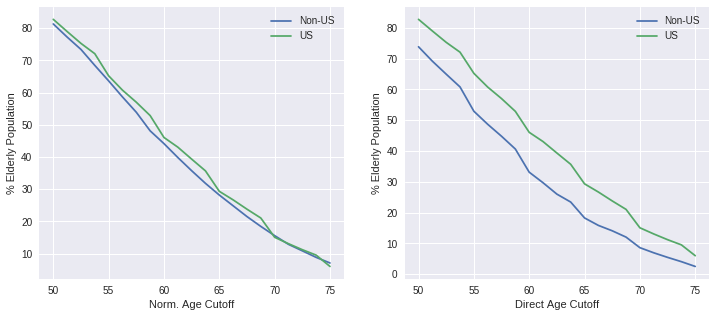

In [21]:
age_cutoffs = np.linspace(50, 75, 21)
eld_adj_ratios = np.zeros((2, len(age_cutoffs)))
eld_ratios = np.zeros((2, len(age_cutoffs)))
print(sum(full_df.US==1), sum(full_df.US==0))
for j, age_cutoff in enumerate(age_cutoffs):
#     print(age_cutoff)
    full_df['elderly'] = full_df['AGE'] > age_cutoff
    full_df['elderly'] = full_df['elderly'].astype(int)

    cut_off = age_cutoff / life_expect[life_expect.COUNTRY=='United States'] \
                                ["Life_Expect"].values[0]
    full_df['elderly_adj'] = full_df['AGE']/full_df['Life_Expect'] > cut_off
    full_df['elderly_adj'] = full_df['elderly_adj'].astype(int)

    for k, feat in enumerate(["elderly_adj", 'elderly']):
        for lab, val in zip(['US', 'Non-US'], [1, 0]):
            idx = full_df['US']==val
            temp = 100*sum(full_df.loc[idx, feat]) / sum(idx)
            if k == 0:
                eld_adj_ratios[val, j] = temp
            else:
                eld_ratios[val, j] = temp

plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.plot(age_cutoffs, eld_adj_ratios[0, :], label='Non-US')
plt.plot(age_cutoffs, eld_adj_ratios[1, :], label='US')
plt.legend()
plt.grid(True)
plt.xlabel('Norm. Age Cutoff')
plt.ylabel('% Elderly Population')
# plt.show()
plt.subplot(122)
plt.plot(age_cutoffs, eld_ratios[0, :], label='Non-US')
plt.plot(age_cutoffs, eld_ratios[1, :], label='US')
plt.legend()
plt.grid(True)
plt.xlabel('Direct Age Cutoff')
plt.ylabel('% Elderly Population')
plt.show()

del full_df["elderly"]
del full_df["elderly_adj"]

In [22]:
full_df.keys(), full_df.shape

(Index(['PROTOCOL', 'STUDYNUM', 'AGE', 'GENDER', 'RACE', 'COUNTRY', 'DAYS_IN',
        'DAYS_TRT', 'DISPOSTN', 'HEIGHT_C', 'WEIGHT_K', 'Life_Expect',
        'ALCOHOL', 'SMOKING', 'AGEGRP', 'HYPGRP', 'DBTGRP', 'CHLGRP', 'ASPFDA',
        'ASCGRP', 'PSTRDS', 'PNSAIDS', 'PNAPRXN', 'PUB_PRIOR_HISTORY',
        'd_event', 'd_event_cfd', 'd_event_cmp', 'p_event', 'p_event_cfd',
        'p_event_cmp', 'b_event', 'b_event_cfd', 'b_event_cmp', 'g_event',
        'g_event_cfd', 'g_event_cmp', 'o_event', 'o_event_cfd', 'o_event_cmp',
        'all_event', 'GI', 'all_event_cmp', 'EVENTDT', 'RAND_DT', 'time_to_GI',
        'cfd_cardio', 'time_to_cfd_cardio', 'all_cardio', 'time_to_all_cardio',
        'just_hypertension', 'time_to_just_hypertension', 'all_hypertension',
        'time_to_all_hypertension', 'cold_cough_flu', 'time_to_cold_cough_flu',
        'naus_vomit_dizz', 'time_to_naus_vomit_dizz', 'TREATED', 'severe_GI',
        'male', 'white', 'US', 'developed', 'BMI', 'overweight', 'obese',


Finally, check number of events for each type of outcome:

In [23]:
outcomes = ["GI", "severe_GI", "all_hypertension", "cfd_cardio", 
            "cold_cough_flu", "naus_vomit_dizz"]
for outcome in outcomes:
    print(f"{outcome}:", full_df[outcome].sum())

GI: 177
severe_GI: 56
all_hypertension: 567
cfd_cardio: 59
cold_cough_flu: 525
naus_vomit_dizz: 707


### 4.3. Discussion of missing values

In [17]:
full_df.isnull().sum()[full_df.isnull().sum() > 0]

HEIGHT_C                35
WEIGHT_K                 1
ALCOHOL                  1
SMOKING                  1
EVENTDT               7886
time_to_GI            7886
time_to_cfd_cardio    8017
time_to_all_cardio    7992
dtype: int64

We just need to discuss how missing values for BMI, ALCOHOL and SMOKING are handled in the later analysis.
We show below that
- 1 NA for SMOKING treated as smoker
- 1 NA for ALCOHOL treated as drinker
- When thresholding for overweight/obese, 35 NA for BMI is treated as being BELOW the threshold (i.e., not overweight or obese)

None of these patients have GI or Cardio events

In [23]:
#full_df[full_df.ALCOHOL.isna()][["drinker", "GI", "cfd_cardio"]]

In [24]:
#full_df[full_df.SMOKING.isna()][["smoker", "GI", "cfd_cardio"]]

In [25]:
#full_df[full_df.BMI.isna()][["obese", "overweight", "GI", "cfd_cardio"]]

## 5. Split data and save

In [27]:
full_df = full_df.reset_index()

We do a stratified split of the data (by treatment and outcome) 6 times, once for each of the outcomes.

In [7]:
EXPORT_PATH = "../../data/01_transformed/20jul2020"

First save the full data

In [74]:
full_df.to_csv(os.path.join(EXPORT_PATH, "full_data.csv"), index = False)

Now do a stratified split for each outcome.

In [31]:
for outcome in outcomes:
    np.random.seed(0)
    trainval_df, test_df = train_test_split(full_df, stratify = \
                                            full_df[outcome] + 2 * full_df["TREATED"], 
                                            test_size = 0.2)
    train_df, val_df = train_test_split(trainval_df, stratify = \
                                        trainval_df[outcome]+ 2 * trainval_df["TREATED"], 
                                        test_size = 0.25)
    os.system("mkdir " + os.path.join(EXPORT_PATH, outcome))
    trainval_df.to_csv(os.path.join(EXPORT_PATH, outcome, "trainval_data.csv"), 
                       index = False)
    train_df.to_csv(os.path.join(EXPORT_PATH, outcome, "train_data.csv"), 
                    index = False)
    val_df.to_csv(os.path.join(EXPORT_PATH, outcome, "val_data.csv"), 
                  index = False)
    test_df.to_csv(os.path.join(EXPORT_PATH, outcome, "test_data.csv"), 
                   index = False)
    
    print(outcome)
    print(train_df[train_df.TREATED==1][outcome].mean() - \
          train_df[train_df.TREATED==0][outcome].mean())
    print(val_df[val_df.TREATED==1][outcome].mean() - \
          val_df[val_df.TREATED==0][outcome].mean())

GI
-0.016199435764924316
-0.016179641563428798
severe_GI
-0.005811048728835221
-0.006217276483236051
cfd_cardio
0.00615322851090166
0.004925972388789885
all_hypertension
0.03689111637993173
0.03795721187025535
cold_cough_flu
0.005896760930776582
0.0059504274185880335
naus_vomit_dizz
0.015288977922036318
0.014534072331432668
